Test of different method to implement the spherical harmonics transform

In [1]:
pip install torch_harmonics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 32.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_harmonics: filename=torch_harmonics-0.8.0-py3-none-any.whl size=162234 sha256=5ca811d85fbdbdd5f360a081c1f6cdcec163629f26789c208a633d2979f64693
  Stored in directory: /root/.cache/pip/wheels/de/35/f6/520d03aca1fd51fda6281591e12d15bfee315dc12de5b0a4af
Successfully built torch_harmonics


In [2]:
import os
import math
import numpy as np
import torch
import torch.nn as nn
import numpy as np

from torch_harmonics import ResampleS2
from torch_harmonics.quadrature import _precompute_latitudes

import matplotlib.pyplot as plt
from torch_harmonics.plotting import plot_sphere

In [3]:
nlat = 257
nlon = 2*(nlat-1)
grid = "equiangular"

xq, wq = _precompute_latitudes(nlat, grid=grid)

let's plot it:

In [4]:
from scipy.interpolate import griddata
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
tensor_data=torch.load("/content/hrtf_test.pt")
incidence=torch.load("/content/incidence.pt")
incidence=np.array(incidence)
incidence[:,0]-=180
data_2=tensor_data.numpy()
right_data=data_2[:,0,:]
theta=np.linspace(-180,175,72,dtype=np.int32)
phi=list(range(-90,90,5))
grid_theta, grid_phi = np.meshgrid(theta, phi,indexing='ij')
grids=np.zeros((128,2,len(phi),len(theta)))



In [8]:

theta=np.linspace(-180,175,72,dtype=np.int32)
phi=list(range(-90,90,5))

N=15
grid_theta, grid_phi = np.meshgrid(theta, phi,indexing='ij')

incidence
Grille=griddata(incidence,right_data[:,N],( grid_theta,grid_phi),method='cubic',fill_value=np.mean(right_data[:,N]))
Grille=np.moveaxis(Grille,0,1)




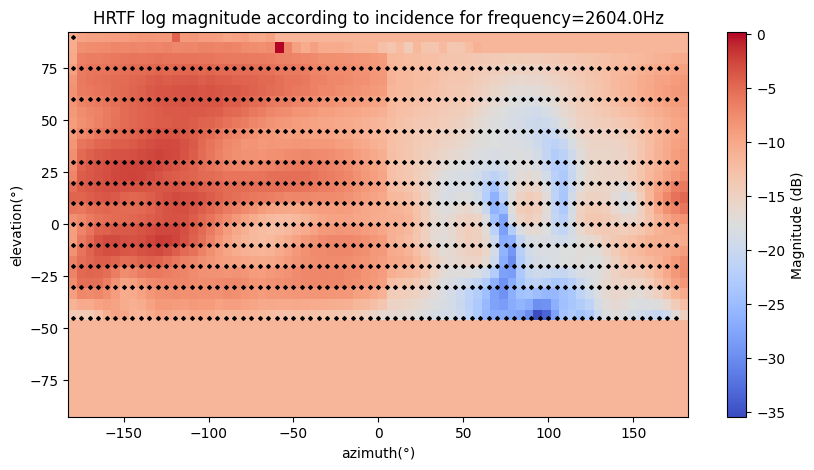

In [9]:
import matplotlib.pyplot as plt
from torch_harmonics.plotting import plot_sphere
nu=np.linspace(0,44100/2,128)
n_lat,n_lon=36,72
lat_grid = np.linspace(-90, 90, n_lat)
lon_grid = np.linspace(-180, 180, n_lon)
lon_g, lat_g = np.meshgrid(lon_grid, lat_grid)

plt.figure(figsize=(10, 5))
plt.pcolormesh(lon_grid, lat_grid, Grille, shading="auto", cmap="coolwarm")
plt.colorbar(label="Magnitude (dB)")
plt.xlabel("azimuth(°)")
plt.ylabel("elevation(°)")
plt.title(f"HRTF log magnitude according to incidence for frequency={np.round(nu[N],0)}Hz")

plt.plot(incidence[:,0], incidence[:,1], 'kx', markersize=2, markeredgewidth=2)
plt.show()


Black points indicate the original measured direction of this HRTF, the other points are interpollates from those measurements.


In [10]:
from torch_harmonics import *
n_theta=36
n_lambda=72
L=35
sht=RealSHT(n_theta, n_lambda,lmax=L,mmax=L+1, grid="equiangular").to(device)
isht=InverseRealSHT(n_theta, n_lambda,lmax=L,mmax=L+1, grid="equiangular").to(device)

In [11]:
sht=RealSHT(36, 72,lmax=L,mmax=L+1, grid="equiangular")
isht=InverseRealSHT(36, 72,lmax=L,mmax=L+1, grid="equiangular")


coeffs = sht(torch.tensor(Grille))
new_coef=isht(coeffs)


In [12]:
from torch_harmonics import *
print(coeffs.shape)

torch.Size([35, 36])


In [13]:
index=np.zeros((793,2),int)
index[:,0]=incidence[:,0]+180
index[:,0]=index[:,0]//5
index[:,1]=incidence[:,1]+75
index[:,1]=index[:,1]//5

In [14]:
print(incidence)

[[-180.  -45.]
 [-180.  -30.]
 [-180.  -20.]
 ...
 [-175.  -20.]
 [-175.  -30.]
 [-175.  -45.]]


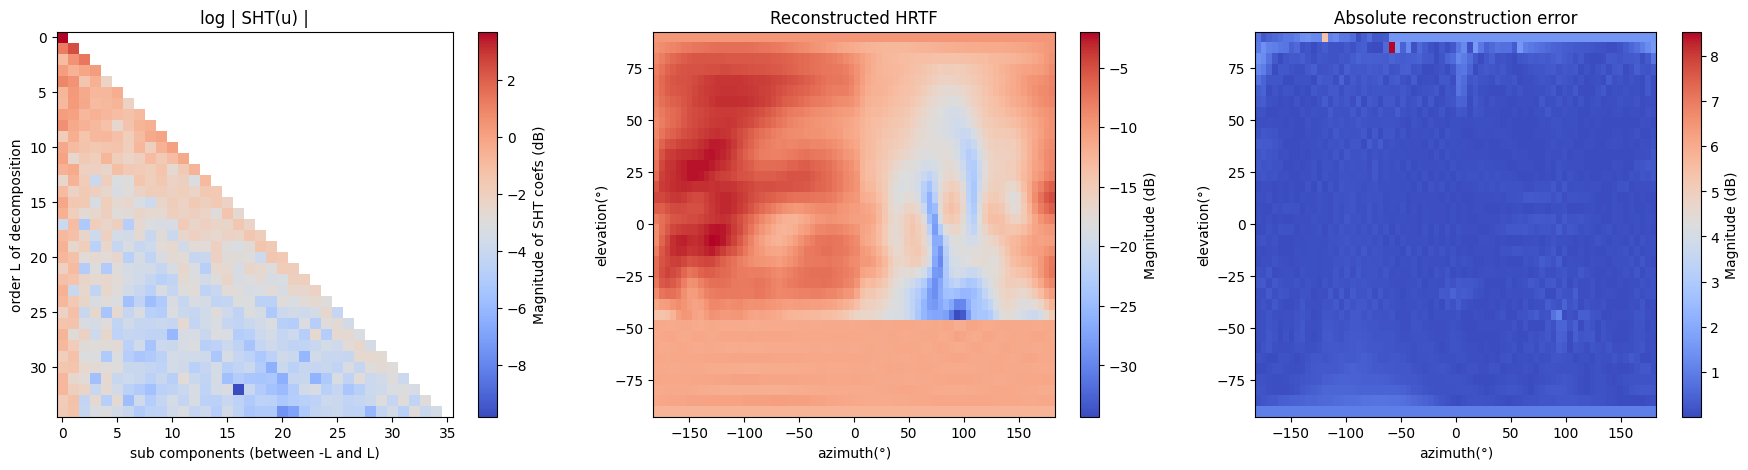

Mean abs reconstruction error for interests points =0.1dB


In [15]:
fig = plt.figure(figsize=(22, 5))
ax = fig.add_subplot(1, 3, 1)
plt.imshow(coeffs.abs().log().cpu(), cmap="coolwarm")
plt.title("log | SHT(u) |")
plt.xlabel("sub components (between -L and L)")
plt.ylabel("order L of decomposition")
plt.colorbar(label="Magnitude of SHT coefs (dB)")

ax = fig.add_subplot(1, 3, 2)
plt.pcolormesh(lon_grid, lat_grid, new_coef,shading="auto", cmap="coolwarm")
plt.xlabel("azimuth(°)")
plt.ylabel("elevation(°)")
ax.set_title("Reconstructed HRTF")
plt.colorbar(label="Magnitude (dB)")

ax = fig.add_subplot(1, 3, 3)
plt.pcolormesh(lon_grid, lat_grid, torch.abs(new_coef-torch.tensor(Grille)),shading="auto", cmap="coolwarm")
plt.xlabel("azimuth(°)")
plt.ylabel("elevation(°)")
ax.set_title("Absolute reconstruction error")
plt.colorbar(label="Magnitude (dB)")
plt.show()

u=abs(new_coef[index[:,1],index[:,0]]-torch.tensor(Grille)[index[:,1],index[:,0]])
H=u.mean().item()
print(f"Mean abs reconstruction error for interests points ={np.round(H,2)}dB")

Mean abs reconstruction error on all frequencies for l=1 =7.4dB
Mean abs reconstruction error on all frequencies for l=2 =3.93dB
Mean abs reconstruction error on all frequencies for l=3 =3.28dB
Mean abs reconstruction error on all frequencies for l=4 =3.04dB
Mean abs reconstruction error on all frequencies for l=5 =2.54dB
Mean abs reconstruction error on all frequencies for l=6 =2.25dB
Mean abs reconstruction error on all frequencies for l=7 =1.95dB
Mean abs reconstruction error on all frequencies for l=8 =1.81dB
Mean abs reconstruction error on all frequencies for l=9 =1.65dB
Mean abs reconstruction error on all frequencies for l=10 =1.49dB
Mean abs reconstruction error on all frequencies for l=11 =1.35dB
Mean abs reconstruction error on all frequencies for l=12 =1.27dB
Mean abs reconstruction error on all frequencies for l=13 =1.15dB
Mean abs reconstruction error on all frequencies for l=14 =1.07dB
Mean abs reconstruction error on all frequencies for l=15 =1.01dB
Mean abs reconstruct

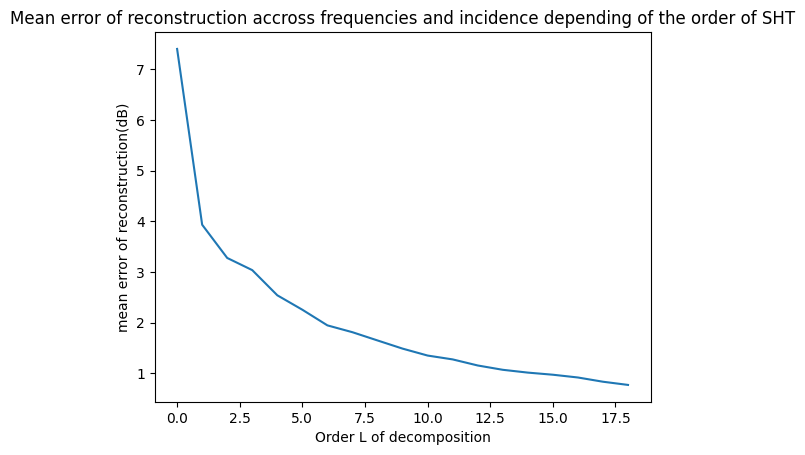

In [19]:
error_L=[]
nu=np.linspace(0,44100/2,128)
for l in range(1,20):
  error_freq=[]
  for i in range(128):
    Grille=griddata(incidence,right_data[:,i],( grid_theta,grid_phi),method='cubic',fill_value=np.mean(right_data[:,i]))
    Grille=np.moveaxis(Grille,0,1)
    sht= RealSHT(n_theta,n_lambda,lmax=l,mmax=l+1, grid="equiangular").to(device)
    isht = InverseRealSHT(n_theta, n_lambda,lmax=l,mmax=l+1, grid="equiangular").to(device)
    coeffs = sht(torch.tensor(Grille).to(device))
    new_coef=isht(coeffs)
    u=abs(new_coef[index[:,1],index[:,0]]-torch.tensor(Grille).to(device)[index[:,1],index[:,0]])
    H=u.mean().item()
    error_freq.append(H)
  error_L.append(np.mean(error_freq))
  print(f"Mean abs reconstruction error on all frequencies for l={l} ={np.round(np.mean(error_freq),2)}dB")
plt.plot(error_L)
plt.xlabel("Order L of decomposition")
plt.ylabel("mean error of reconstruction(dB)")
plt.title("Mean error of reconstruction accross frequencies and incidence depending of the order of SHT")
plt.show()



In [20]:
def Calculate_SHT_coef(HRTF_y_set_L,HRTF_y_set_R,incidence,L):
    SHT_coef =np.zeros((HRTF_y_set_L.shape[-1],2,L,L+1)) # num_freq, real/ima, lmax+1, lmax+1, left/right ear
    incidence=np.array(incidence)
    theta=np.linspace(-180,175,72,dtype=np.int32)
    phi=list(range(-90,90,5))
    grid_theta, grid_phi = np.meshgrid(theta, phi,indexing='ij')
    SHT_transform=RealSHT(36, 72,lmax=L,mmax=L+1, grid="equiangular",csphase=True)
    IR_L=HRTF_y_set_L
    IR_R=HRTF_y_set_R
    grille_gauche_freq=np.zeros((128,36,72))
    grille_droite_freq=np.zeros((128,36,72))
    for j in range(HRTF_y_set_L.shape[1]): #On parcourt les fréquences
        f_grid_l=griddata(incidence,IR_L[:,j],( grid_theta,grid_phi),method='nearest',fill_value=-100)
        f_grid_l=np.moveaxis(f_grid_l,0,1)
        grille_gauche_freq[j,:,:]=f_grid_l
        f_grid_l=torch.tensor(f_grid_l, dtype=torch.float32)
        coeffs1 = SHT_transform(f_grid_l)
        SHT_coef[j,0,:,:]=np.array(coeffs1.type(torch.float32))
        f_grid_r=griddata(incidence,IR_R[:,j],( grid_theta,grid_phi),method='cubic',fill_value=-100)
        f_grid_r=np.moveaxis(f_grid_r,0,1)
        grille_droite_freq[j,:,:]=f_grid_r
        f_grid_r=torch.tensor(f_grid_r, dtype=torch.float32)
        coeffs = SHT_transform(f_grid_r)
        SHT_coef[j,1,:,:]=np.array(coeffs.type(torch.float32))
    return SHT_coef,grille_gauche_freq,grille_droite_freq

def Calculate_inverse_grid(SHT_coef,L):
    theta=np.linspace(-180,175,72)
    phi=list(range(-90,90,5))
    SHT_inv_transform=InverseRealSHT(36, 72,lmax=L,mmax=L+1, grid="equiangular")
    if len(SHT_coef.shape)==5:
        grids=np.zeros((SHT_coef.shape[0],128,2,len(phi),len(theta)))
        for j in range(SHT_coef.shape[0]):
           for l in range(SHT_coef.shape[1]):
                SHT_coef_L=torch.from_numpy(SHT_coef[j,l,0,:,:]).type(torch.complex64)
                SHT_coef_R=torch.from_numpy(SHT_coef[j,l,1,:,:]).type(torch.complex64)
                SHT_coef_L=SHT_coef_L.unsqueeze(dim=0)
                SHT_coef_R=SHT_coef_R.unsqueeze(dim=0)
                grids[j,l,0,:,:]=np.array(SHT_inv_transform(torch.permute(SHT_coef_L,(0,1,2))))
                grids[j,l,1,:,:]=np.array(SHT_inv_transform(torch.permute(SHT_coef_R,(0,1,2))))

    else:
        grids=np.zeros((128,2,len(phi),len(theta)))
        for j in range(SHT_coef.shape[0]):
           SHT_coef_L=torch.from_numpy(SHT_coef[j,0,:,:]).type(torch.complex64)
           SHT_coef_R=torch.from_numpy(SHT_coef[j,1,:,:]).type(torch.complex64)
           SHT_coef_L=SHT_coef_L.unsqueeze(dim=0)
           SHT_coef_R=SHT_coef_R.unsqueeze(dim=0)
           grids[j,0,:,:]=np.array(SHT_inv_transform(torch.permute(SHT_coef_L,(0,1,2))))
           grids[j,1,:,:]=np.array(SHT_inv_transform(torch.permute(SHT_coef_R,(0,1,2))))
    return grids

In [21]:
import matplotlib.pyplot as plt
nu=np.linspace(0,44100/2,128)


/tmp/ipython-input-285977481.py:18: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /pytorch/aten/src/ATen/native/Copy.cpp:309.)
  SHT_coef[j,0,:,:]=np.array(coeffs1.type(torch.float32))


mean diff left=6.646462940770206dB, std=4.868813185732532dB
mean diff right=6.614617884896486dB, std=8.51684680777225dB


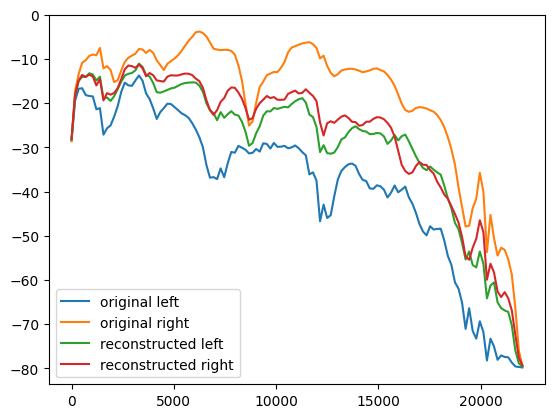

In [22]:
data_2=data_2.astype(np.double)
HRTF_L=data_2[:,0,:]
HRTF_R=data_2[:,1,:]
L=35
SHT_coef,grid_left,grid_right=Calculate_SHT_coef(HRTF_L,HRTF_R,incidence,L)
SHT_coef[:,0,0,0]=SHT_coef[:,0,0,0]
SHT_coef[:,1,0,0]=SHT_coef[:,1,0,0]
grids=Calculate_inverse_grid(SHT_coef,L)

grid_left_pred=grids[:,0,:,:]
grid_right_pred=grids[:,1,:,:]

diff_left,std_left=np.mean(np.abs(grid_left-grid_left_pred)),np.std(np.abs(grid_left-grid_left_pred))
diff_right,std_right=np.mean(np.abs(grid_right-grid_right_pred)),np.std(np.abs(grid_right-grid_right_pred))
print(f"mean diff left={diff_left}dB, std={std_left}dB")
print(f"mean diff right={diff_right}dB, std={std_right}dB")

plt.plot(nu,grid_left[:,18,47],label="original left")
plt.plot(nu,grid_right[:,18,47],label="original right")
plt.plot(nu,grid_left_pred[:,18,47],label="reconstructed left")
plt.plot(nu,grid_right_pred[:,18,47],label="reconstructed right")
plt.legend()
plt.show()




In [23]:
HRTF = np.random.randn(793, 128)       # matrice HRTF (793 directions x 128 fréquences)
incidence=torch.load("/content/incidence.pt")
incidence=np.array(incidence)
incidence=incidence*(np.pi/180) # élévation [-π/2, π/2]

# ===============================
# Conversion azimut/élévation → theta/phi
# ===============================
theta = incidence[:,0]                # azimut
phi =incidence[:,1]-np.pi/2

Ordre optimal N=49 avec erreur RMS=0.9704


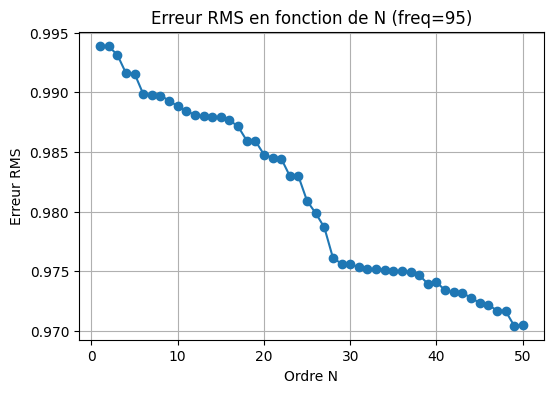

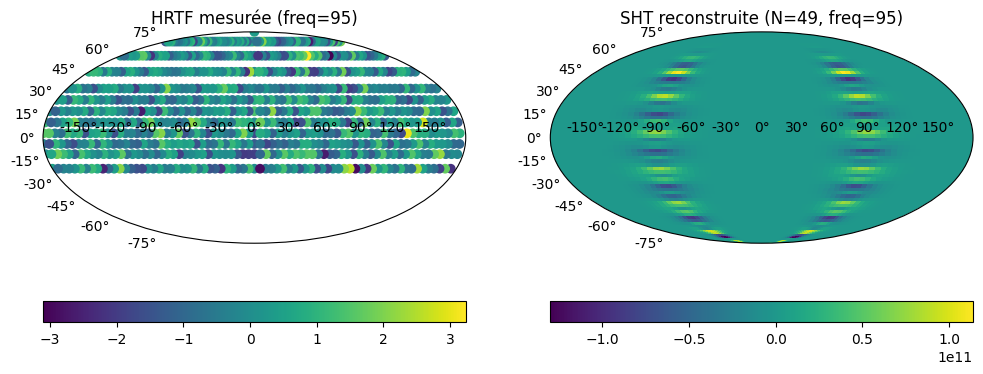

In [24]:
from scipy.special import sph_harm_y


# ===============================
# Données factices (à remplacer)
# ===============================
HRTF = np.random.randn(793, 128)       # matrice HRTF (793 directions x 128 fréquences)
incidence=torch.load("/content/incidence.pt")
incidence=np.array(incidence)
incidence=incidence*(np.pi/180) # élévation [-π/2, π/2]

# ===============================
# Conversion azimut/élévation → theta/phi
# ===============================
theta = incidence[:,0]                # azimut
phi =incidence[:,1]-np.pi/2

# ===============================
# Base SHT
# ===============================
def sph_basis(N, theta, phi):
    basis = []
    for n in range(N+1):
        for m in range(-n, n+1):
            basis.append(sph_harm_y(m, n, theta, phi))
    return np.array(basis).T  # shape (num_points, (N+1)^2)

# ===============================
# Paramètres
# ===============================
freq_idx = 95  # index de fréquence à analyser
Nmax =   50   # ordre max à tester

f_measured = HRTF[:, freq_idx]
rms_errors = []

# ===============================
# Boucle sur les ordres N
# ===============================
for N in range(1, Nmax+1):
    Y = sph_basis(N, theta, phi)
    coeffs, _, _, _ = np.linalg.lstsq(Y, f_measured, rcond=None)
    f_recon_meas = (Y @ coeffs).real
    rms_error = np.sqrt(np.mean((f_measured - f_recon_meas)**2))
    rms_errors.append(rms_error)

# Ordre optimal
N_opt = np.argmin(rms_errors) + 1
print(f"Ordre optimal N={N_opt} avec erreur RMS={rms_errors[N_opt-1]:.4f}")

# ===============================
# Visualisation erreur RMS
# ===============================
plt.figure(figsize=(6,4))
plt.plot(range(1, Nmax+1), rms_errors, marker="o")
plt.xlabel("Ordre N")
plt.ylabel("Erreur RMS")
plt.title(f"Erreur RMS en fonction de N (freq={freq_idx})")
plt.grid(True)
plt.show()

# ===============================
# Reconstruction sur toute la sphère avec N_opt
# ===============================
n_grid = 72
theta_grid = np.linspace(0, 2*np.pi, n_grid)
phi_grid = np.linspace(0, np.pi, n_grid)
THETA, PHI = np.meshgrid(theta_grid, phi_grid)

Y_opt = sph_basis(N_opt, theta, phi)
coeffs_opt, _, _, _ = np.linalg.lstsq(Y_opt, f_measured, rcond=None)

Y_full = sph_basis(N_opt, THETA.ravel(), PHI.ravel())
f_recon_grid = (Y_full @ coeffs_opt).reshape(PHI.shape)

# Reconstruit aussi sur les points mesurés pour l’échelle de couleur
f_recon_meas = (Y_opt @ coeffs_opt).real

vmin = min(f_measured.min(), f_recon_grid.real.min())
vmax = max(f_measured.max(), f_recon_grid.real.max())

fig, axs = plt.subplots(1, 2, figsize=(12,5), subplot_kw={'projection': 'mollweide'})

# Original
sc0 = axs[0].scatter(theta-np.pi, np.pi/2-phi, c=f_measured,
                     cmap="viridis")
axs[0].set_title(f"HRTF mesurée (freq={freq_idx})")
fig.colorbar(sc0, ax=axs[0], orientation="horizontal")

# Reconstruction
im1 = axs[1].pcolormesh(THETA-np.pi, np.pi/2-PHI, f_recon_grid.real,
                        cmap="viridis", shading="auto")
axs[1].set_title(f"SHT reconstruite (N={N_opt}, freq={freq_idx})")
fig.colorbar(im1, ax=axs[1], orientation="horizontal")

plt.show()


In [29]:
print(incidence)

[[ 0.         -0.7853982 ]
 [ 0.         -0.5235988 ]
 [ 0.         -0.34906584]
 ...
 [ 0.08726646 -0.34906584]
 [ 0.08726646 -0.5235988 ]
 [ 0.08726646 -0.7853982 ]]


✅ GPU détecté : utilisation de CuPy


/tmp/ipython-input-1849188412.py:35: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  basis.append(sph_harm(m, n, theta, phi))


RMS global (complex) sur directions mesurées = 4.267110e-02
RMS global (magnitude) sur directions mesurées = 4.266816e-02


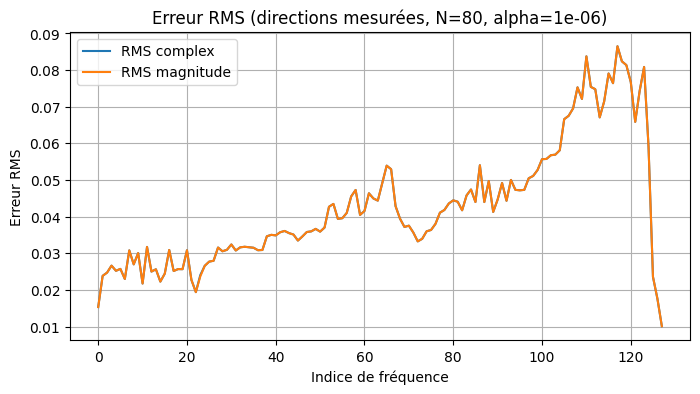

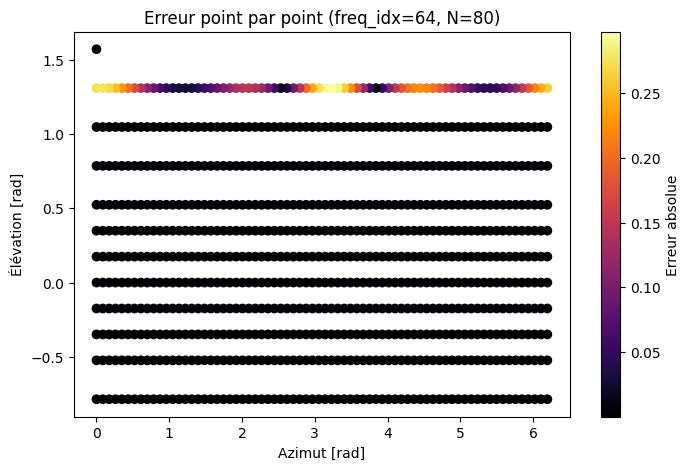

In [35]:


# ------------------------
# Choix backend (GPU si dispo, sinon CPU)
# ------------------------
try:
    import cupy as cp
    _ = cp.zeros(1)  # test allocation
    xp = cp
    gpu_available = True
    print("✅ GPU détecté : utilisation de CuPy")
except Exception as e:
    cp = np  # pour éviter les erreurs si tu utilises cp par mégarde
    xp = np
    gpu_available = False
    print("⚠️ Pas de GPU détecté : utilisation de NumPy (CPU)")

# ------------------------
# CONFIGURATION
# ------------------------
N = 80              # ordre SH
alpha = 1e-6        # régularisation
save_coeffs = False

# ------------------------
# Fonctions utilitaires
# ------------------------
def sph_basis(N, theta, phi):
    # Calcul via SciPy (toujours CPU), puis transfert si GPU
    basis = []
    for n in range(N+1):
        for m in range(-n, n+1):
            basis.append(sph_harm(m, n, theta, phi))
    basis = np.array(basis).T
    return xp.asarray(basis, dtype=np.complex128)

# ------------------------
# Suppose que HRTF et incidence existent
# HRTF.shape = (793, 128)
# incidence.shape = (793, 2)
# ------------------------

n_dirs, n_freqs = HRTF.shape
theta = incidence[:,0]                 # azimut (0..2π)
phi = np.pi/2 - incidence[:,1]         # colatitude (0..π)

# Matrice de base
Y = sph_basis(N, theta, phi)

# HRTF sur backend choisi
F = xp.asarray(HRTF, dtype=np.complex128)   # (n_dirs, n_freqs)

# ------------------------
# Résolution batchée
# ------------------------
YH = xp.conjugate(Y).T
A = YH @ Y
if alpha > 0:
    A += alpha * xp.eye(A.shape[0], dtype=np.complex128)

B = YH @ F   # ( (N+1)^2, n_freqs )

# Résolution en bloc
coeffs_all = xp.linalg.solve(A, B)   # C

# Reconstruction en bloc
recon_measured = Y @ coeffs_all      # (n_dirs, n_freqs)

# ------------------------
# Erreurs RMS
# ------------------------
diff = F - recon_measured
rms_per_freq_complex = xp.sqrt(xp.mean(xp.abs(diff)**2, axis=0))
rms_per_freq_mag = xp.sqrt(xp.mean((xp.abs(F) - xp.abs(recon_measured))**2, axis=0))

# Conversion CPU pour affichage
if gpu_available:
    rms_global_complex = float(rms_per_freq_complex.mean().get())
    rms_global_mag = float(rms_per_freq_mag.mean().get())
    rms_per_freq_complex_cpu = rms_per_freq_complex.get()
    rms_per_freq_mag_cpu = rms_per_freq_mag.get()
    recon_measured_cpu = recon_measured.get()
else:
    rms_global_complex = float(rms_per_freq_complex.mean())
    rms_global_mag = float(rms_per_freq_mag.mean())
    rms_per_freq_complex_cpu = rms_per_freq_complex
    rms_per_freq_mag_cpu = rms_per_freq_mag
    recon_measured_cpu = recon_measured

print(f"RMS global (complex) sur directions mesurées = {rms_global_complex:.6e}")
print(f"RMS global (magnitude) sur directions mesurées = {rms_global_mag:.6e}")

# ------------------------
# Visualisations
# ------------------------
theta_cpu = theta
elev_cpu = np.pi/2 - phi

plt.figure(figsize=(8,4))
plt.plot(np.arange(n_freqs), rms_per_freq_complex_cpu, label="RMS complex")
plt.plot(np.arange(n_freqs), rms_per_freq_mag_cpu, label="RMS magnitude")
plt.xlabel("Indice de fréquence")
plt.ylabel("Erreur RMS")
plt.title(f"Erreur RMS (directions mesurées, N={N}, alpha={alpha})")
plt.legend()
plt.grid(True)
plt.show()

# Exemple visuel : point par point à une fréquence
freq_idx_show = n_freqs // 2
diff_show = np.abs(HRTF[:, freq_idx_show] - recon_measured_cpu[:, freq_idx_show])

plt.figure(figsize=(8,5))
sc = plt.scatter(theta_cpu, elev_cpu, c=diff_show, cmap="inferno")
plt.colorbar(sc, label="Erreur absolue")
plt.title(f"Erreur point par point (freq_idx={freq_idx_show}, N={N})")
plt.xlabel("Azimut [rad]")
plt.ylabel("Élévation [rad]")
plt.show()


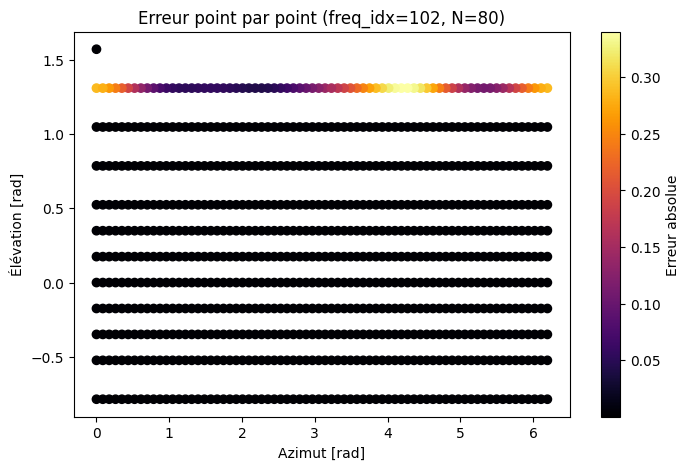

In [36]:
freq_idx_show = 102
diff_show = np.abs(HRTF[:, freq_idx_show] - recon_measured_cpu[:, freq_idx_show])

plt.figure(figsize=(8,5))
sc = plt.scatter(theta_cpu, elev_cpu, c=diff_show, cmap="inferno")
plt.colorbar(sc, label="Erreur absolue")
plt.title(f"Erreur point par point (freq_idx={freq_idx_show}, N={N})")
plt.xlabel("Azimut [rad]")
plt.ylabel("Élévation [rad]")
plt.show()